<a href="https://colab.research.google.com/github/wanxing2/Wine-Clustering/blob/main/Stat430_Final_Project_Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STAT 430 Final Project: Wine Data Set Clustering**
Jing Huang(jingh7)

Wanxing Dai(wanxing2)

## Dataset Research

**Citations**

1.
“UCI Machine Learning Repository: Wine Data Set.” UCI Machine Learning Repository, 1991, [archive.ics.uci.edu/ml/datasets/Wine](http://archive.ics.uci.edu/ml/datasets/Wine).

(This **website** gives us much information on this dataset and it tells us where to find more of it.)

2.
Wade, AdrianP., and KevinA. Soulsbury. “PARVUS An Extendable Package of Programs for Data Exploration, Classification of Correlation.” TrAC Trends in Analytical Chemistry, vol. 8, no. 10, 1989, pp. 386–87. Crossref, doi:10.1016/0165-9936(89)85082-4.

(It is said to be the original source of the dataset. But I didn't find an evidence for that. Also there's no explanation on how the data is gathered. So we didn't get much information from it.)

3.
Rishidamarla. “2D&3D PCA, t-SNE, and UMAP on Wine Dataset.” Kaggle, 1 Sept. 2020, www.kaggle.com/rishidamarla/2d-3d-pca-t-sne-and-umap-on-wine-dataset#2D-T-distributed-Stochastic-Neighbour-Embedding.

(This is a kaggle notebook that runs PCA/T-SNE on the same dataset. We first read it to see if this dataset is truely clustarable, and after we finished our own T-SNE, we compared our results with his.)

**Data gathering**

In [1] it said that "This data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars." And from [2] we know that the experiement is conducted before 1989. It contains information of 178 wines and 13 attributes of the wine. And they come from 3 different wine types. 


**Attributes**

1. Alcohol content 
2. Malic acid
3. Ash
4. Alcalinity of ash
5. Magnesium
6. Total phenols
7. Flavanoids
8. Nonflavanoid phenols
9. Proanthocyanins
10. Color intensity
11. Hue
12. OD280/OD315 of diluted wines
13. Proline
14. Wine class - this is the label of the wine

**Why we use this dataset?**
1. First and most importantly, the data is proved to be clusterable by other researchers.
2. People may want to know whether or not these three types of wine are different from/relate with each other. Clustering (unsupervised learning) is focusing on telling us how similar wines of the same type are, and how different they are with wines from other types.

In [ ]:
!pip install pyclustertend
!pip install scikit-fuzzy

In [ ]:
import numpy as np
import pandas as pd
from itertools import chain
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from gensim import corpora, models, similarities, matutils
import sklearn
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import adjusted_rand_score, silhouette_samples, silhouette_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from skfuzzy.cluster import cmeans
from scipy.spatial.distance import pdist, squareform
from pyclustertend import hopkins

In [ ]:
# import data
# --------------------------------------------
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My Drive/STAT430Final Project/
# df = pd.read_csv('wine.csv')
df = pd.read_csv("https://raw.githubusercontent.com/hjfsg95/XiaoHuang/gh-pages/wine.csv")
print("shape: ", df.shape)
df.head()

shape:  (178, 14)


,Wine Class,Alcohol Content,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid Phenols,Proanthocyanins,Color Intensity,Hue,OD280 or OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Data cleaning

In [ ]:
# check missing values
# --------------------------------------------
print("Count of missing values in each column:")
df.isna().sum()

Count of missing values in each column:


Wine Class                         0
Alcohol Content                    0
Malic Acid                         0
Ash                                0
Alcalinity of Ash                  0
Magnesium                          0
Total Phenols                      0
Flavanoids                         0
Nonflavanoid Phenols               0
Proanthocyanins                    0
Color Intensity                    0
Hue                                0
OD280 or OD315 of diluted wines    0
Proline                            0
dtype: int64

In [ ]:
df.columns

Index(['Wine Class', 'Alcohol Content', 'Malic Acid', 'Ash',
       'Alcalinity of Ash', 'Magnesium', 'Total Phenols', 'Flavanoids',
       'Nonflavanoid Phenols', 'Proanthocyanins', 'Color Intensity', 'Hue',
       'OD280 or OD315 of diluted wines', 'Proline'],
      dtype='object')

In [ ]:
df.duplicated().sum()

0

There is no missing data or duplicate. We are ready to start explore the data.

## **Preliminary Exploratory Data Analysis (EDA)**

Since the dataset is very clean, we don't have to do data cleaning on it. So we will jump directly to the EDA part. We are mainly interested in several things:

1. The basic statistics of each attributes (all of the 13 attributes are numerical)
3. Is there any outliers in the dataset?
4. Should I scale my dataset?
5. The pairwise relationship between attributes.

## **Pre-Analysis Questions**




### Basic statistics

In [ ]:
# define X and Y
# --------------------------------------------
X = df.drop("Wine Class", axis=1).copy()
Y = df["Wine Class"]

# descriptive statistics
# --------------------------------------------
X.describe()

,Alcohol Content,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid Phenols,Proanthocyanins,Color Intensity,Hue,OD280 or OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


By looking at this table, we can answer several questions:

**Is there any outliers in the dataset?**

Not really. The quantiles of each column look normal. Only in the Proline column the maximum value is much larger than the 75% quantile, but we think it is still a reasonable value.

**Should I scale my dataset?**

Yes, because different columns have different mean-scale values. For example, the mean of Proline is 300 times larger than that of Malic Acid. And we would do a a standardization on both the mean and std.

In [ ]:
# standardize the data
# --------------------------------------------
sX = StandardScaler().fit_transform(X)
X = pd.DataFrame(sX, columns=X.columns)
X.describe()

,Alcohol Content,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid Phenols,Proanthocyanins,Color Intensity,Hue,OD280 or OD315 of diluted wines,Proline
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,-8.619821e-16,-8.357859e-17,-8.657245e-16,-1.160121e-16,-1.995907e-17,-2.972030e-16,-4.016762e-16,4.079134e-16,-1.699639e-16,-1.247442e-18,3.717376e-16,2.919013e-16,-7.484650e-18
std,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00
min,-2.434235e+00,-1.432983e+00,-3.679162e+00,-2.671018e+00,-2.088255e+00,-2.107246e+00,-1.695971e+00,-1.868234e+00,-2.069034e+00,-1.634288e+00,-2.094732e+00,-1.895054e+00,-1.493188e+00
25%,-7.882448e-01,-6.587486e-01,-5.721225e-01,-6.891372e-01,-8.244151e-01,-8.854682e-01,-8.275393e-01,-7.401412e-01,-5.972835e-01,-7.951025e-01,-7.675624e-01,-9.522483e-01,-7.846378e-01
50%,6.099988e-02,-4.231120e-01,-2.382132e-02,1.518295e-03,-1.222817e-01,9.595986e-02,1.061497e-01,-1.760948e-01,-6.289785e-02,-1.592246e-01,3.312687e-02,2.377348e-01,-2.337204e-01
75%,8.361286e-01,6.697929e-01,6.981085e-01,6.020883e-01,5.096384e-01,8.089974e-01,8.490851e-01,6.095413e-01,6.291754e-01,4.939560e-01,7.131644e-01,7.885875e-01,7.582494e-01
max,2.259772e+00,3.109192e+00,3.156325e+00,3.154511e+00,4.371372e+00,2.539515e+00,3.062832e+00,2.402403e+00,3.485073e+00,3.435432e+00,3.301694e+00,1.960915e+00,2.971473e+00


Now we can take a look at the class labels:

In [ ]:
# descriptive statistics of Y
Y.value_counts()

2    71
1    59
3    48
Name: Wine Class, dtype: int64

There are **three types of wine**, and they are distributed quite uniformly, while the second wine type has a bit more wines than the other two.

### Pairwise relationship

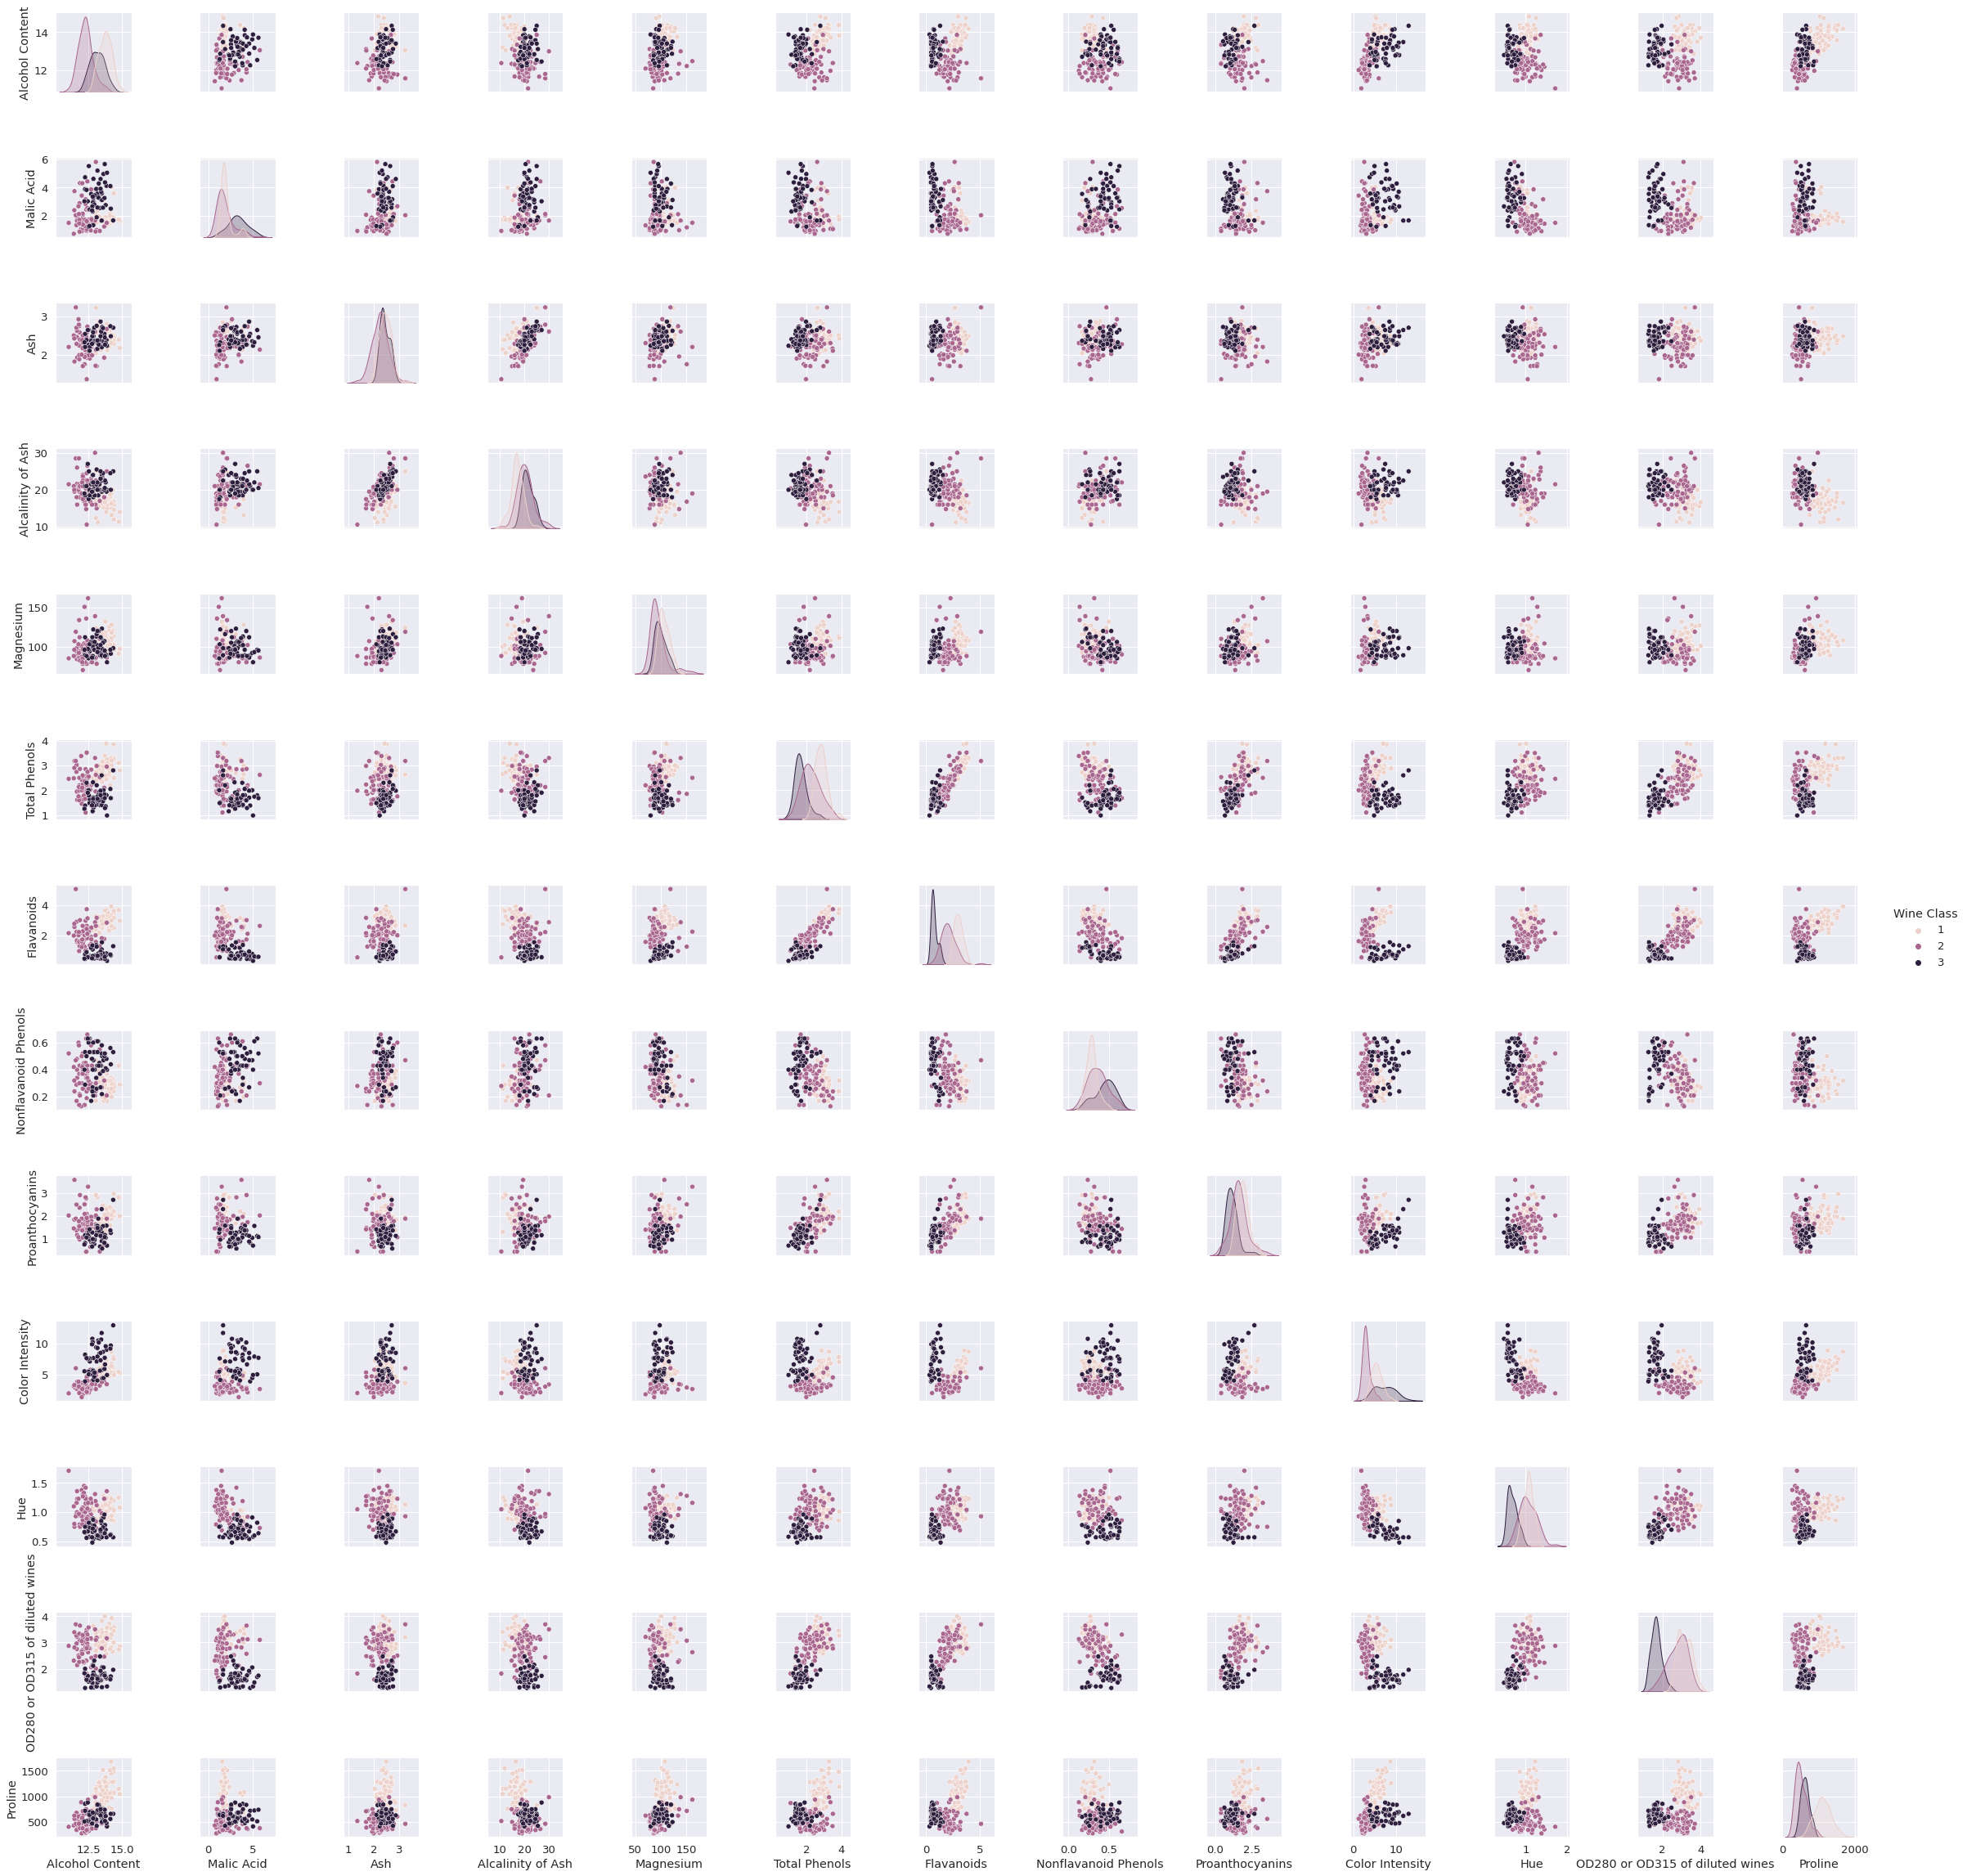

In [ ]:
# pairwise plot on X
# --------------------------------------------
# sns.pairplot(pd.DataFrame(X))
sns.set()

with sns.plotting_context("notebook", font_scale=1.2):
    sns.pairplot(df,
                 vars=['Alcohol Content', 'Malic Acid', 'Ash', 'Alcalinity of Ash', 'Magnesium', 'Total Phenols', 'Flavanoids', 'Nonflavanoid Phenols', 'Proanthocyanins', 'Color Intensity', 'Hue', 'OD280 or OD315 of diluted wines', 'Proline'],
                 hue="Wine Class")

plt.show()

We found that there's a relatively high correlation between Flavanoids and other variables including Total Phenols.

**Is the dataset clusterable?**

  Based on the hopkins statistics and the t-sne plot, the answer is yes. We also checked other research papers/kaggle notebooks to see what other people have done, and found that it is highly acknowledged that this is a great dataset for running clustering algorithms.

**What are the shapes of the underlying clusters?**

  The underlying cluseters are spherical.

**Are the clusters balanced in size?**

  The clusters are relatively balanced in size.


**Do any of the clusters that you identified overlap with each other?**

  There are few outliers but most of the points are well separated from each other.

## Dataset Suitability Pre-Analysis

### Clusterability Check 1: Hopkins statistics

In [ ]:
n=len(X)
num_trials=5
hopkins_stats=[]
for i in range(0,num_trials):
    n = len(X)
    p = int(0.1 * n)
    hopkins_stats.append(hopkins(X,p))
print(hopkins_stats)

[0.2914808280933211, 0.2610277386941617, 0.31266760587693676, 0.26852820833620455, 0.2919050130068175]


The data is clutserable as the hopkins statistics are close to 0.

### Clusterability Check 2: t-SNE Plots

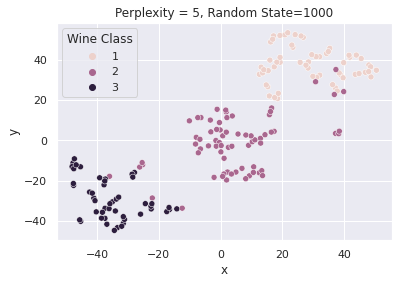

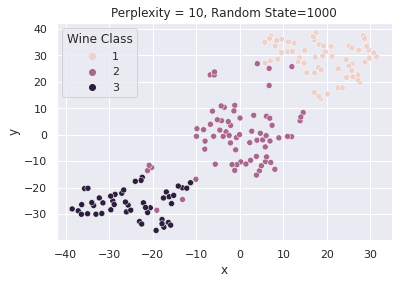

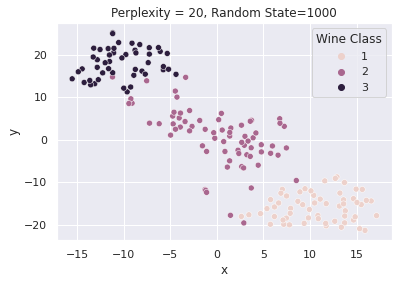

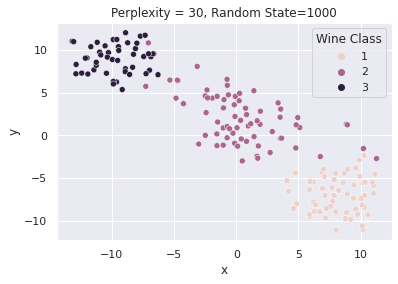

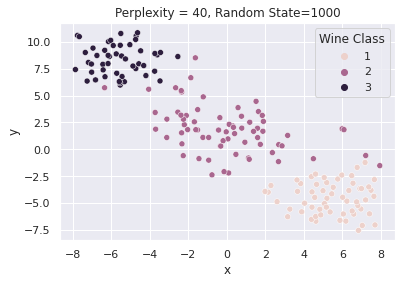

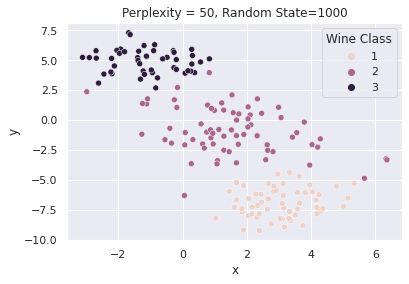

In [ ]:
for perp in [5, 10, 20, 30, 40, 50]:
    # Perform the TSNE non-linear dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=perp, random_state=1000)
    data_tsne = tsne.fit_transform(X)

    #concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
    df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df.index)
    dff = pd.concat([df_tsne, df], axis=1)

    # Plot the projected (x,y) coordinates
    sns.scatterplot(x='x', y='y', hue = 'Wine Class', data=dff)
    plt.title('Perplexity = %s, Random State=1000' %perp)
    plt.show()

**Choosing the Perplexity Value(s):**

We see that perplexity values of 30 has the most compact groups. This gives evidence to the idea that the shape of the underlying clusters most resembles what we see in the plots made with the perplexities of 30.

**Clusterability Interpretation with t-SNE:**

This dataset shows distinct large clouds of data for the perplexity values of 10, 20, 30, 40, and 50. Thus there is evidence that this dataset is clusterable.

**Other information with t-sne (types of clusters):**
* We can see one highly distinct spherical cluster.
* We can see a few overlapping elements.
* It looks like the clusters are around the same size.

**Relationship of the Class Labels and t-sne clustering structure**
* It looks like some class labels do not all belong to together in the same cluster.



## **Algorithm Selection Motivation**

To decide which clustering algorithms to use, we need to first answer these questions:


**Is the dataset seperable by euclidean distance?**

We can't answer this question now, but we can answer it after we run a clustering algorithm that is based on euclidean distance. So the first algorithm we are going to try is the k-means algorithm. If it works, we would keep using it; if it doesn't work, we would then consider under distance metrics.

**Do we want to do a hard assignment?**

The answer is Yes. Because a wine can belong and only belongs to one wine type, And we want to seperate them apart as much as possible. So we would not allow the clusters to overlap.

**Are we interested in the probability of clustering assignment?**

The answer is yes. It would be interesting to see how "certainly" a wine belongs to a specific type. We might also want to compare the hard assignment result with soft assignment, to see if there's any difference between them. Hence, we will also consider using a fuzzy cmeans algorithm.

**Do we expect there to be any sub-clusters?**

The answer is yes. We assumes that there are different "sub-types" lying in each of the three wine classes, which might be influenced the year, creater of the wine. However, we don't know the truth of it. We just think it's worth exploring - as a result of this thought, we decide to use one of the hierarchical clustering algorithms.


With all the answers above, we chose K-Means, hieracrhical clustering and fuzzy cmeans.

## Clustering Algorithm 1: K-Means Clustering

In [ ]:
cluster_number_list = range(1,12)
avg_inertia_list = []
for k in cluster_number_list:
  sub_inertia_list=[]
  for i in range(0,3):
    kmeans=KMeans(n_clusters=k).fit(X)
    sub_inertia_list.append(kmeans.inertia_)
  avg_inertia_list.append(np.average(sub_inertia_list))

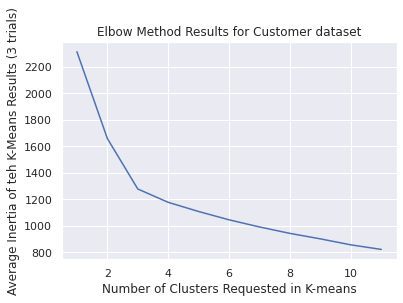

In [ ]:
plt.plot(cluster_number_list, avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of teh K-Means Results (3 trials)')
plt.title('Elbow Method Results for Customer dataset')
plt.show()

**Interpretation:**
This elbow plot starts to level off at k=3 clusters. So the elbow plot is indicating that k-means will perform best with 3 clusters.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=1000).fit(X)
df['predicted_cluster_kmeans'] = kmeans.labels_
df

,Wine Class,Alcohol Content,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid Phenols,Proanthocyanins,Color Intensity,Hue,OD280 or OD315 of diluted wines,Proline,predicted_cluster_kmeans
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,1
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,1
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,1
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,1


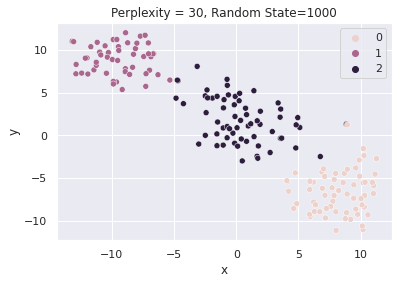

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=1000)
data_tsne = tsne.fit_transform(X)

#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df.index)
dff = pd.concat([df_tsne, df], axis=1)

# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue = 'predicted_cluster_kmeans', data=dff)
plt.title('Perplexity = 30, Random State=1000')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### **Post-Analysis**

**Seperation and cohesion**



In [ ]:
silhouette_avg = silhouette_score(X, df['predicted_cluster_kmeans'])
silhouette_avg

0.2848589191898987

The closer this score is to 1, the more cohesive and separated these clustering is. So an average silhouette score of 0.28 is somewhat low.

**Cluster attributes**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


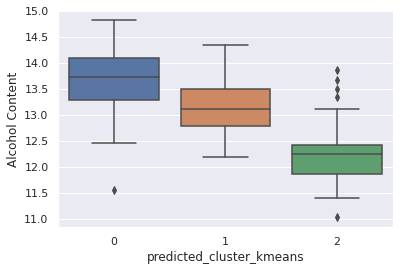

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


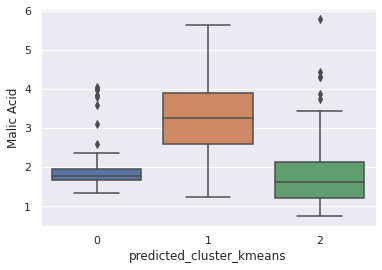

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


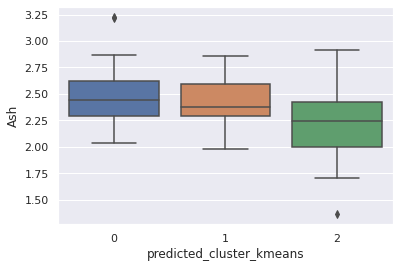

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


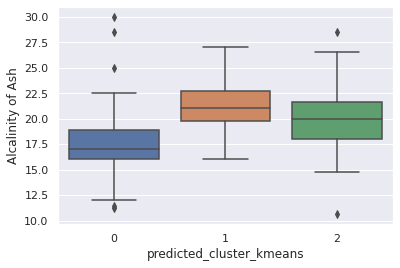

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


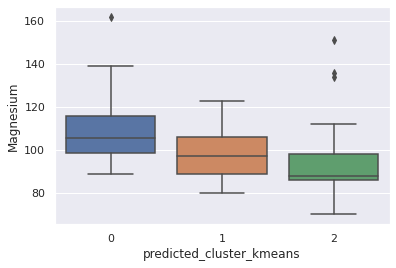

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


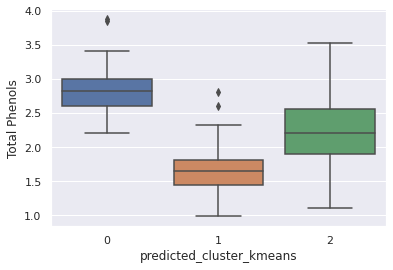

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


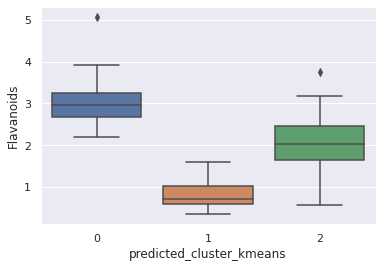

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


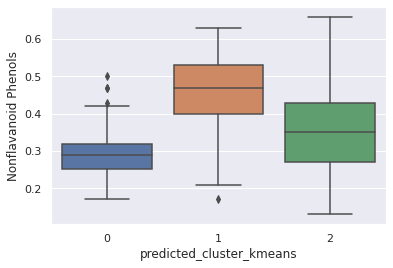

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


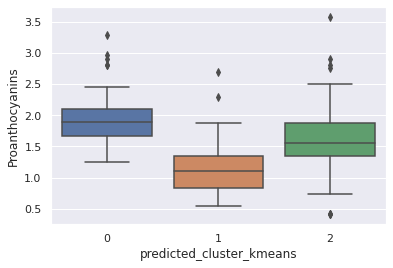

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


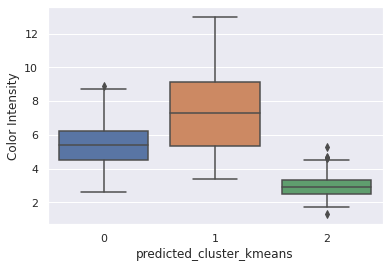

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


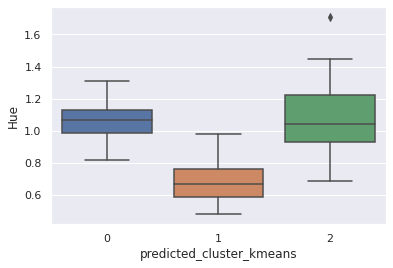

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


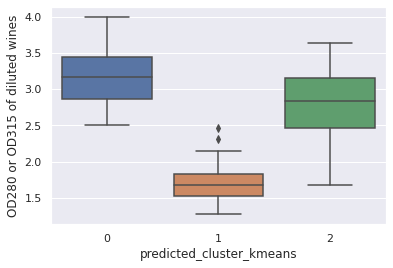

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


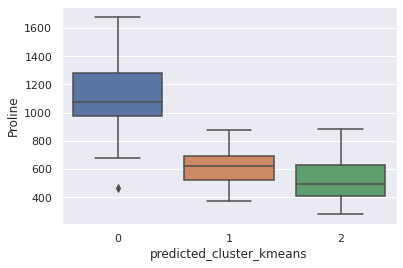

In [ ]:
for col in X:
  sns.boxplot(df["predicted_cluster_kmeans"], y=df[col])
  plt.show()

The cluster with index 0 has the highest alcohol content, Magnesium, Total ohenois, Ash, Flavanoids, Proathocyanins, OD280 or OD315 of diluted wines, and Proline. The cluster with index 1 has the highest Malic Acid, Monflavanoid, Phenois, Color intensity.

**Supervised learning evaluation**

Confusion Matrix:

In [ ]:
# Confusion matrix
y_actu = pd.Series(Y, name='Actual')
y_pred = pd.Series(df['predicted_cluster_kmeans'], name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

df_confusion

Predicted,0,1,2
Actual,,,
1,59,0,0
2,3,3,65
3,0,48,0


The confusion matrix looks good. For wine class 1 and 3, our kmeans have 100% accuracy; for wine class 2, we misclassified some of the wines to other clusters.

And in our cluster 2, there are only wines from class 2. But in cluster 0 and 1, there are also wines that come from other classes.

Adjusted Rand Score:

In [ ]:
adjusted_rand_score(df['predicted_cluster_kmeans'], Y)

0.8974949815093207

Homogeneity Score:

In [ ]:
homogeneity_score(df['predicted_cluster_kmeans'], Y)

0.8729636016078731

Completeness Score:

In [ ]:
completeness_score(df['predicted_cluster_kmeans'], Y)

0.8788432003662366

V Measure Score:

In [ ]:
v_measure_score(df['predicted_cluster_kmeans'], Y)

0.875893534122307

The four metrics are all large enough (> 0.87), which means our clustering result highly agrees with the true wine types.

Distance Matrix:

In [ ]:
df_sort=df.sort_values(by=['predicted_cluster_kmeans'])
df_sort=df_sort.drop(['Wine Class','predicted_cluster_kmeans'], axis=1)
df_sort.head()

,Alcohol Content,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid Phenols,Proanthocyanins,Color Intensity,Hue,OD280 or OD315 of diluted wines,Proline,predicted_cluster_ward
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,2
33,13.76,1.53,2.70,19.5,132,2.95,2.74,0.50,1.35,5.40,1.25,3.00,1235,2
34,13.51,1.80,2.65,19.0,110,2.35,2.53,0.29,1.54,4.20,1.10,2.87,1095,2
35,13.48,1.81,2.41,20.5,100,2.70,2.98,0.26,1.86,5.10,1.04,3.47,920,2
36,13.28,1.64,2.84,15.5,110,2.60,2.68,0.34,1.36,4.60,1.09,2.78,880,2


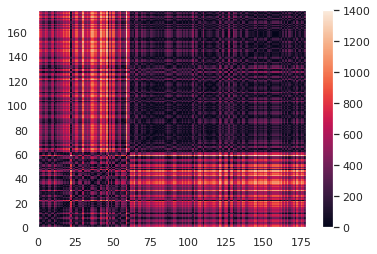

In [ ]:
#Create a distance matrix
dist_mat = squareform(pdist(df_sort))
N = len(df_sort)
plt.pcolormesh(dist_mat)
plt.colorbar()
plt.xlim([0,N])
plt.ylim([0,N])
plt.show()

The three clusters show relatively high cohesion (when using euclidean distance to measure cluster closeness). (Because we saw that our clusters in the t-sne plot were roughly spherical, using euclidean distance to measure cluster closeness is a fair assumption).

It looks like cluster (with index 1) has the least cohesion. There are a few yellow vertical lines in the second block, and their corresponding values in rows 65-120 are much darker.

It looks like cluster (with index 0) has the largest cluster.

It looks like cluster with index 2 and the cluster with index 0 are the closest apart clusters.

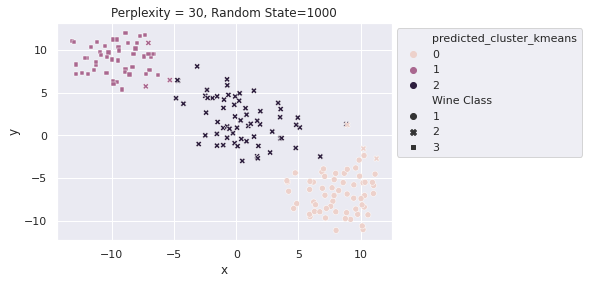

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=1000)
data_tsne = tsne.fit_transform(X)

#concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df.index)
dff = pd.concat([df_tsne, df], axis=1)

# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', hue = 'predicted_cluster_kmeans', style = 'Wine Class', data=dff)
plt.title('Perplexity = 30, Random State=1000')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

The T-SNE plot further gives us information on how well our kmeans algorithm is. Actually our kmeans highly agrees with T-SNE plot, which we can see from the plot that the colors of the point comply with the shape of T-SNE clusters. However, by looking at the shape of the points, we see that both T-SNE and kmeans didn't match some of the wines to the correct cluster. We thought that these wines might be actually "closer" to wines in other classes, and that causes our algorithms to confuse.

## Clustering Algorithm 2: Hierarchical Clustering 

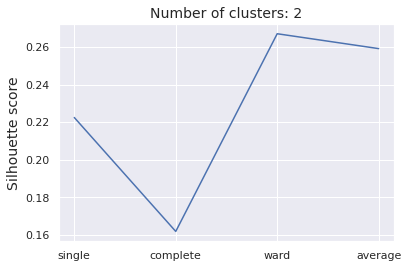

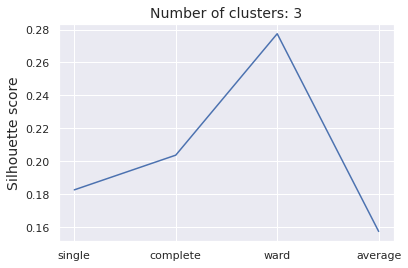

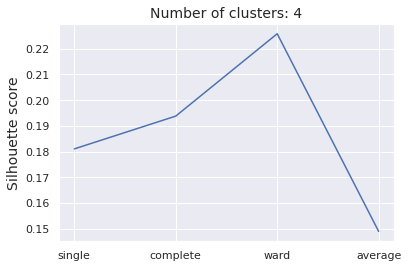

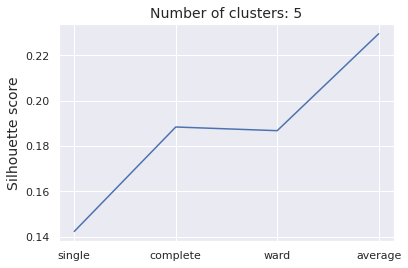

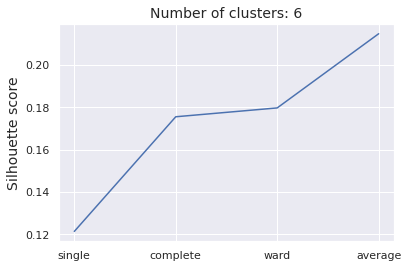

In [ ]:
nb_clusters = [2, 3, 4, 5, 6]
linkages = ['single', 'complete', 'ward', 'average']

silhouette_scores = np.zeros(shape=(len(linkages), len(nb_clusters)))

for i, l in enumerate(linkages):
    for j, nbc in enumerate(nb_clusters):
        ag = AgglomerativeClustering(n_clusters=nbc, affinity='euclidean', linkage=l)
        Y_pred = ag.fit_predict(sX)
        sls = silhouette_score(sX, Y_pred, random_state=1000)
        silhouette_scores[i, j] = sls

for i in range(len(nb_clusters)):
    plt.plot(silhouette_scores[:, i])
    plt.ylabel('Silhouette score', fontsize=14)
    plt.title('Number of clusters: {}'.format(nb_clusters[i]), fontsize=14)
    plt.xticks(np.arange(len(linkages)), linkages)
    plt.show()

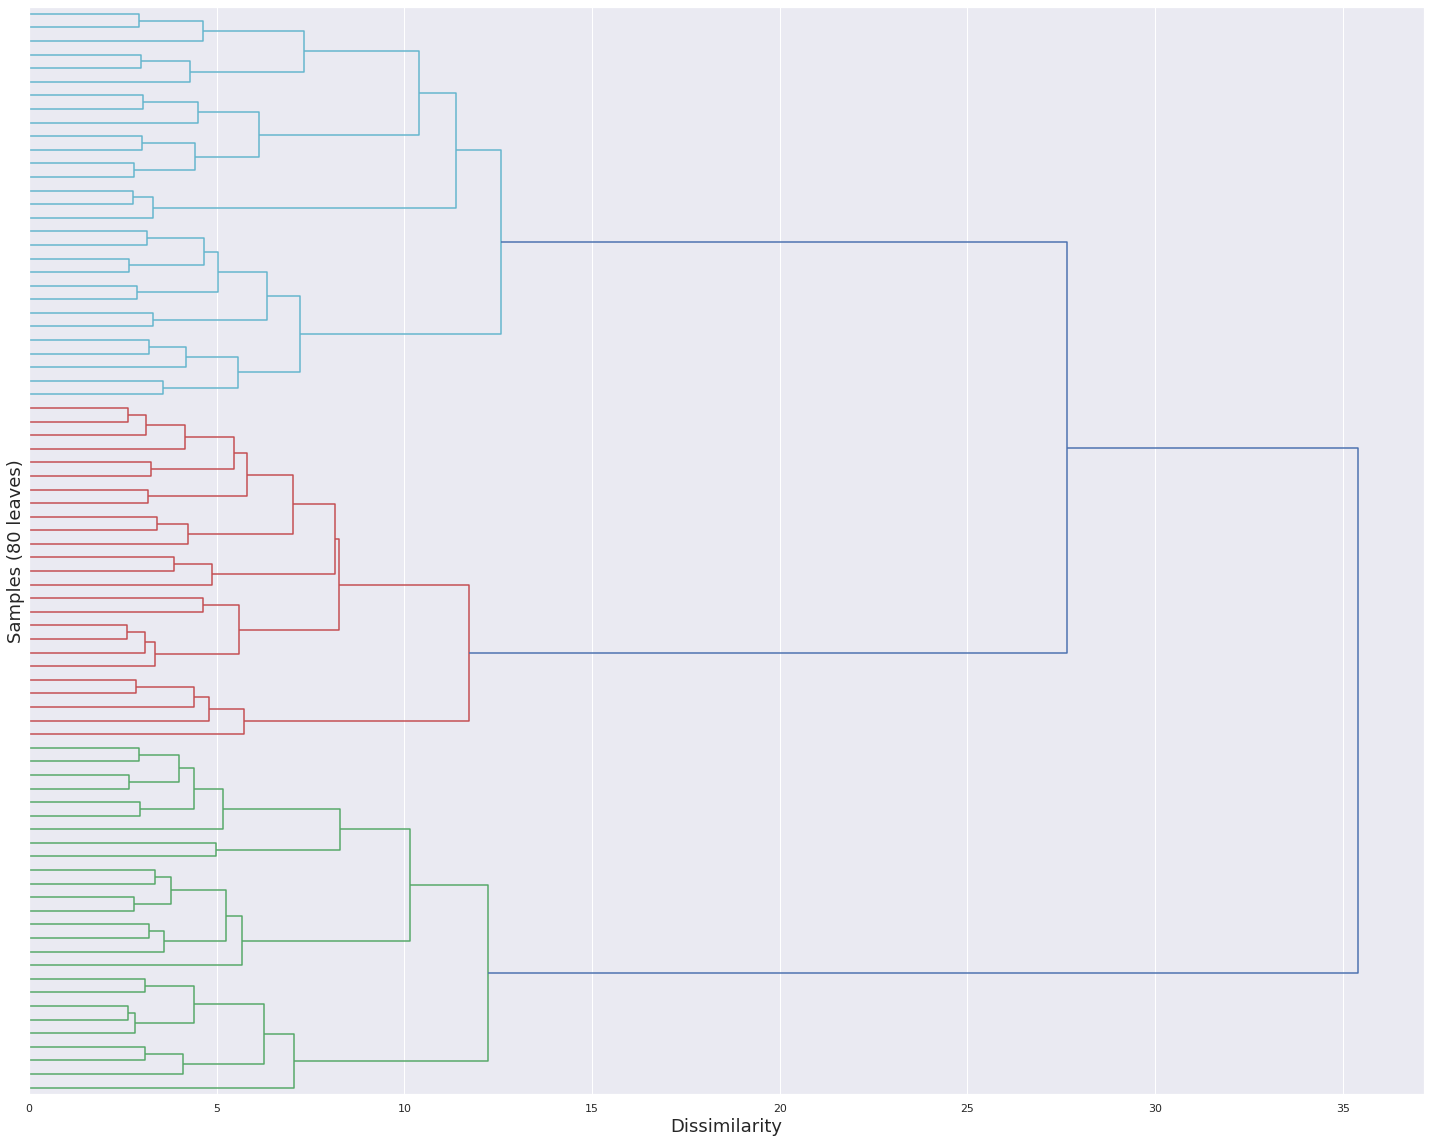

In [ ]:
# Show the truncated dendrogram for a ward linkage
dm = pdist(sX, metric='euclidean')
Z = linkage(dm, method='ward')

fig, ax = plt.subplots(figsize=(25, 20))

d = dendrogram(Z, orientation='right', truncate_mode='lastp', p=80, no_labels=True, ax=ax)

ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Samples (80 leaves)', fontsize=18)

plt.show()

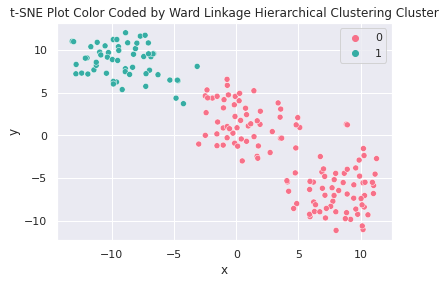

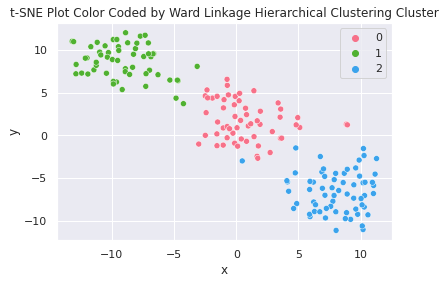

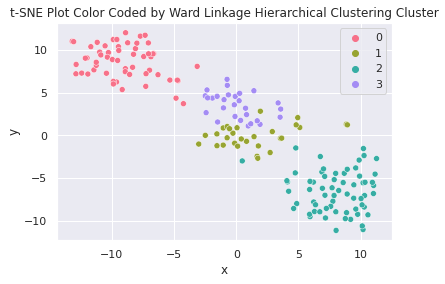

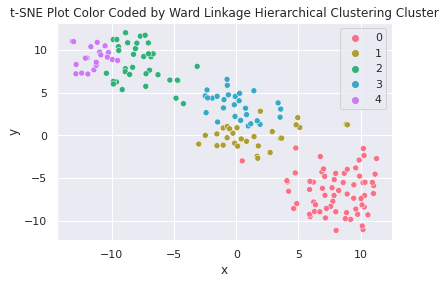

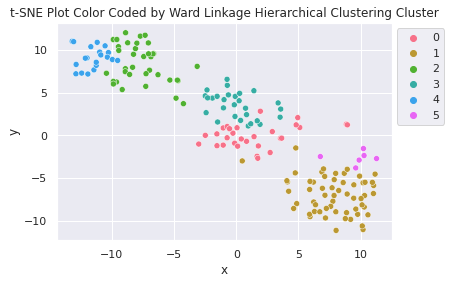

In [ ]:
#What do these clusters look like on the t-sne plot, can we determine any additional pattern to these clusters?
for n in (2,3,4,5,6):
    ag = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    Y_pred = ag.fit_predict(X)

    df_pred = pd.Series(Y_pred, name='Cluster', index=df.index)


    tsne = TSNE(n_components=2, perplexity=30, random_state=1000)
    data_tsne = tsne.fit_transform(X)
    #concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
    df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df.index)
    dff = pd.concat([df_tsne, df], axis=1)

    pdff = pd.concat([dff, df_pred], axis=1)

    # Show the results of the clustering
    sns.scatterplot(x='x',y='y', hue='Cluster', palette=sns.color_palette("husl", n),data=pdff)
    plt.title('t-SNE Plot Color Coded by Ward Linkage Hierarchical Clustering Cluster')
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

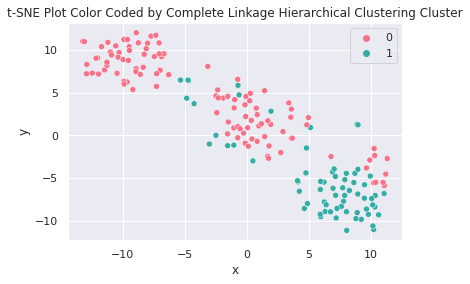

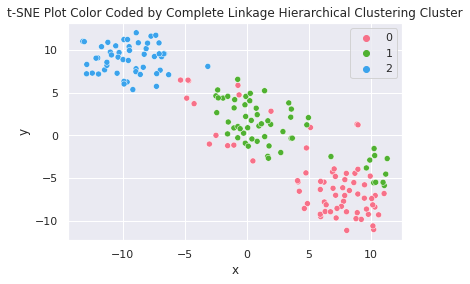

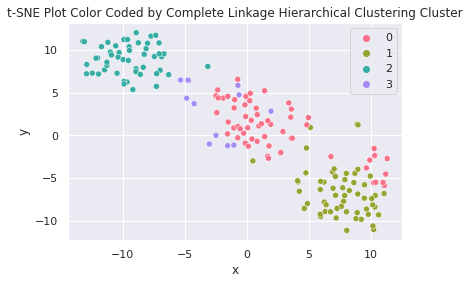

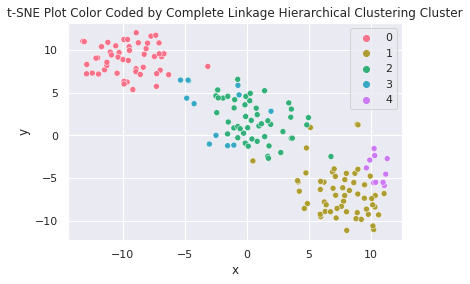

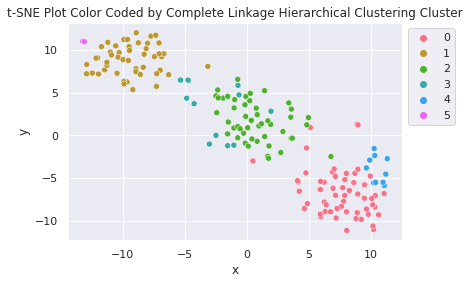

In [ ]:
#What do these clusters look like on the t-sne plot, can we determine any additional pattern to these clusters?
for n in (2,3,4,5,6):
    ag = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='complete')
    Y_pred = ag.fit_predict(X)

    df_pred = pd.Series(Y_pred, name='Cluster', index=df.index)


    tsne = TSNE(n_components=2, perplexity=30, random_state=1000)
    data_tsne = tsne.fit_transform(X)
    #concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
    df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df.index)
    dff = pd.concat([df_tsne, df], axis=1)

    pdff = pd.concat([dff, df_pred], axis=1)

    # Show the results of the clustering
    sns.scatterplot(x='x',y='y', hue='Cluster', palette=sns.color_palette("husl", n),data=pdff)
    plt.title('t-SNE Plot Color Coded by Complete Linkage Hierarchical Clustering Cluster')
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

Ward linkage was able to appropriately split the clusters from quite easily (complete linkage was not able to do this.)

In [ ]:
ag = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
df['predicted_cluster_ward'] = ag.fit_predict(X)

### **Post-Analysis**

**Seperation and cohesion**

In [ ]:
silhouette_avg = silhouette_score(X, df['predicted_cluster_ward'])
silhouette_avg

0.2774439826952266

The average Silhouette score is low, and lower than that of the kmeans. This means that our hierarchical clustering has generally higher seperation and cohesion than kmeans - the clusters are more "focused".

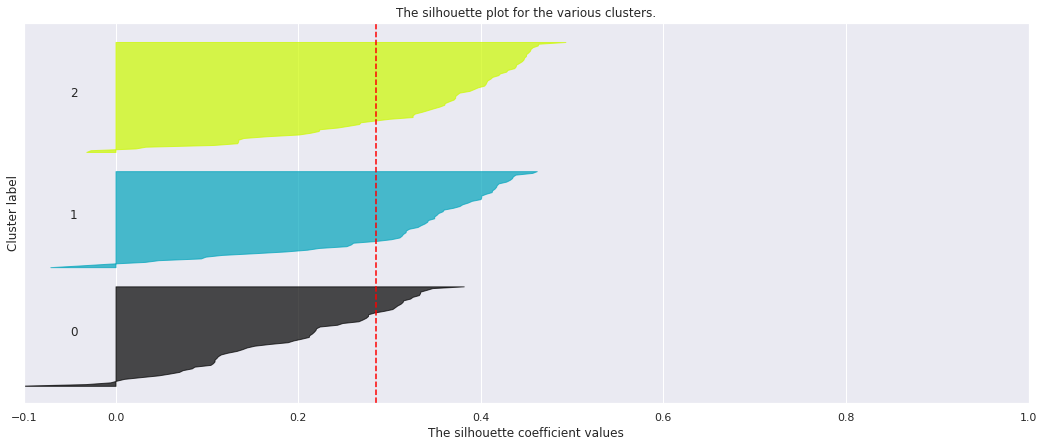

In [ ]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, df['predicted_cluster_ward'])

n_clusters=len(df['predicted_cluster_ward'].unique())


fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[df['predicted_cluster_ward'] == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


plt.show()

Here in the Silhouette plot, we see that cluster 2 and cluster 1 looks better than cluster 0. And in all of these three clusters there are points with negative Silhouette coefficient, which means they are closer to wines from other clusters than wines from its own cluster.

**Cluster attributes**

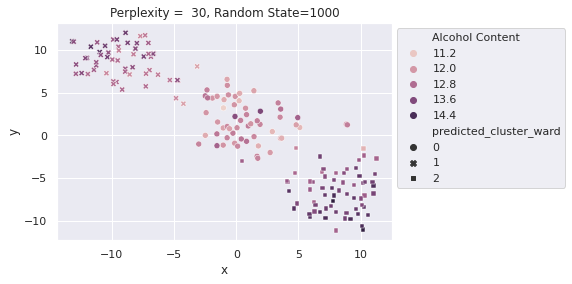

In [ ]:
dff = pd.concat([df_tsne, df], axis=1)
sns.scatterplot(x='x', y='y', style='predicted_cluster_ward', hue='Alcohol Content', data=dff)
plt.title('Perplexity =  30, Random State=1000')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

The alcohol content is successful in seperating the middle cluster out from others (it has lower alcohol content in general). And the top/bottom clusters have higher alcohol content.

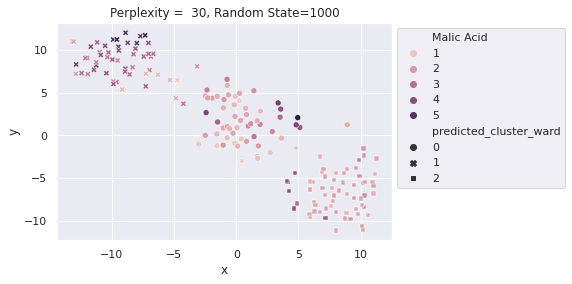

In [ ]:
sns.scatterplot(x='x', y='y', style='predicted_cluster_ward', hue='Malic Acid', data=dff)
plt.title('Perplexity =  30, Random State=1000')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

It seems that Malic Acid is not that good for seperating different clusters. But generally, we can see that the middle and bottom clusters have relatively lower malic acid.

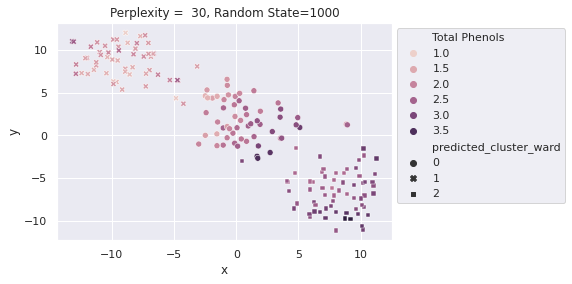

In [ ]:
sns.scatterplot(x='x', y='y', style='predicted_cluster_ward', hue='Total Phenols', data=dff)
plt.title('Perplexity =  30, Random State=1000')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

The Total Phenols has a strong pattern here: from top to bottom, the total phenols in wines increase. We see that the top cluster has lower total phenols, the bottom cluster has higher total phenols, while the middle one is mixed with lower total phenols and higher total phenols.

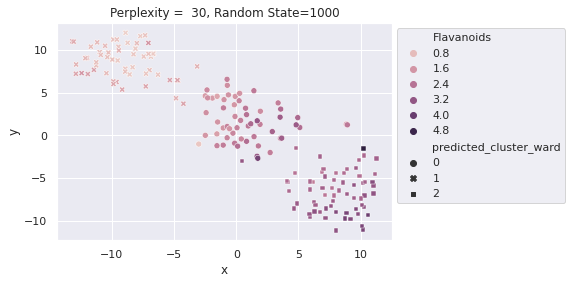

In [ ]:
sns.scatterplot(x='x', y='y', style='predicted_cluster_ward', hue='Flavanoids', data=dff)
plt.title('Perplexity =  30, Random State=1000')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

The flavanoids behaves similar to the total phenols. That is reasonable because we already checked and confirmed that these two variables have a high positive relationship. 

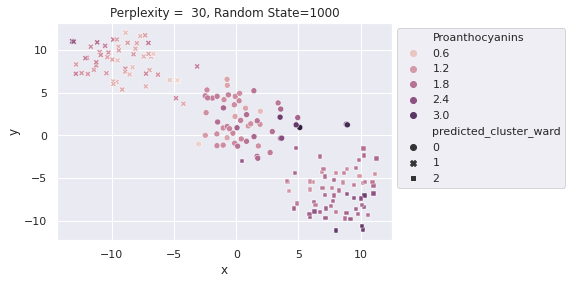

In [ ]:
sns.scatterplot(x='x', y='y', style='predicted_cluster_ward', hue='Proanthocyanins', data=dff)
plt.title('Perplexity =  30, Random State=1000')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

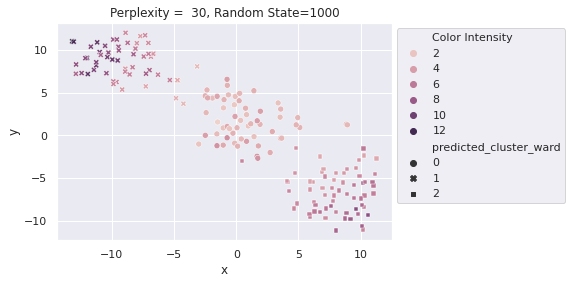

In [ ]:
sns.scatterplot(x='x', y='y', style='predicted_cluster_ward', hue='Color Intensity', data=dff)
plt.title('Perplexity =  30, Random State=1000')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

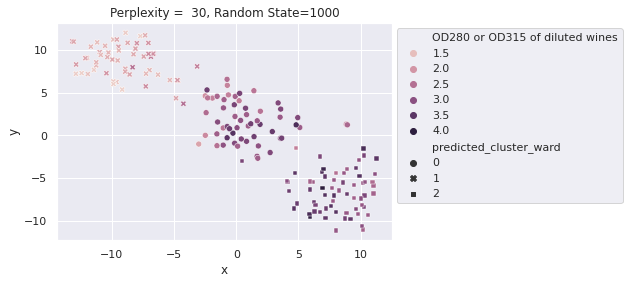

In [ ]:
sns.scatterplot(x='x', y='y', style='predicted_cluster_ward', hue='OD280 or OD315 of diluted wines', data=dff)
plt.title('Perplexity =  30, Random State=1000')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

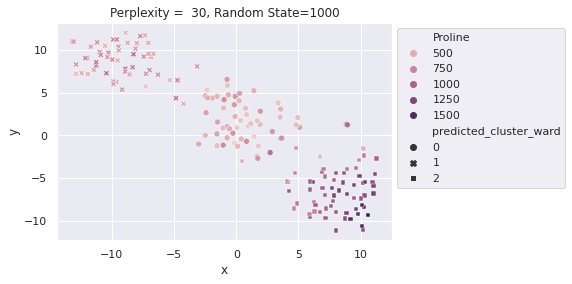

In [ ]:
sns.scatterplot(x='x', y='y', style='predicted_cluster_ward', hue='Proline', data=dff)
plt.title('Perplexity =  30, Random State=1000')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

For the other variables shown here, there are patterns that distinguish different clusters. So they are all contributing in doing the clustering job.

**Supervised learning evaluation**

Adjusted Rand index

In [ ]:
adjusted_rand_score(df['predicted_cluster_ward'], Y)

0.7899332213582837

In [ ]:
homogeneity_score(df['predicted_cluster_ward'], Y)

0.7825408201875712

In [ ]:
completeness_score(df['predicted_cluster_ward'], Y)

0.790429271831654

In [ ]:
v_measure_score(df['predicted_cluster_ward'], Y)

0.7864652657004838

The adjusted rand index, homogeneity score and completeness score are around 0.7. They are a bit lower than the result of kmeans, which means it does not perform as good as kmeans when compared to the real classes. But remember that it has higher overall seperation and cohesion than kmeans. So from this we can see that the seperation and cohesion of the real classes are not very large. It is **not true** that a higher seperation and cohesion will lead us to a more accurate classification result.

## Clustering Algorithm 3: Fuzzy c-Means

For Fuzze c-means, we didn't want to see how correct it is when doing the clustering job. We are interested in the probability of wines belonging to a cluster, and we want to see how different a soft assignment is with the hard assignments. So we won't go that deep into the details and results of Fuzzy c-means. 

In [ ]:
X_array=np.array(X).T

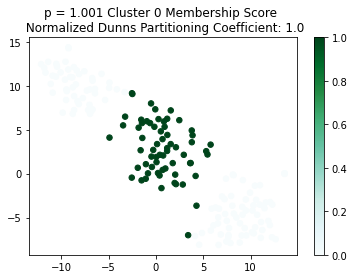

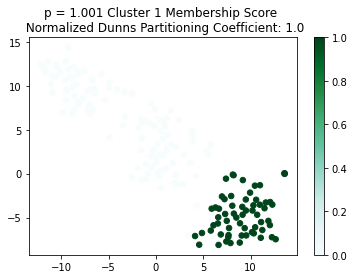

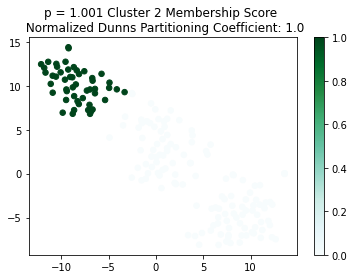

----------------------------------------


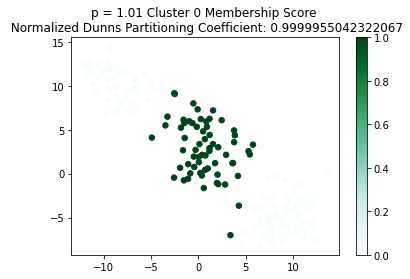

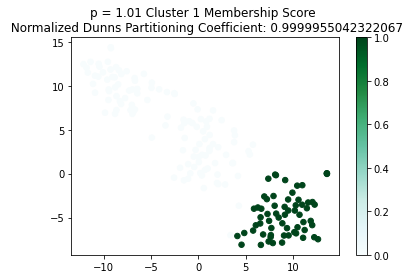

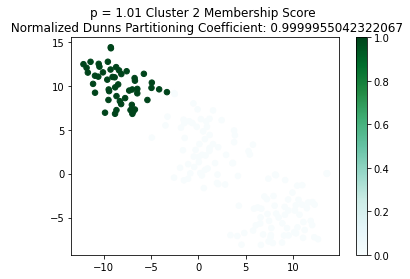

----------------------------------------


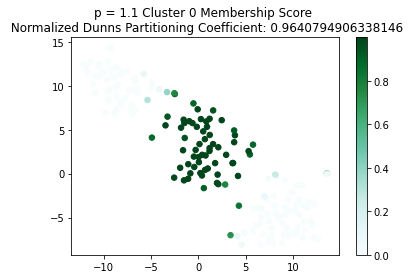

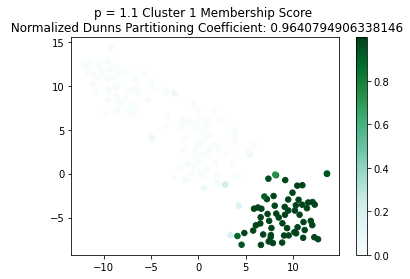

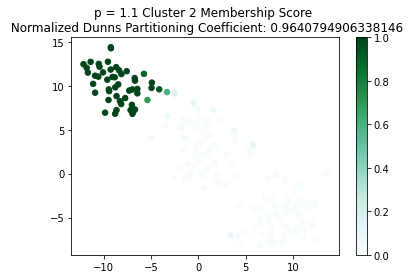

----------------------------------------


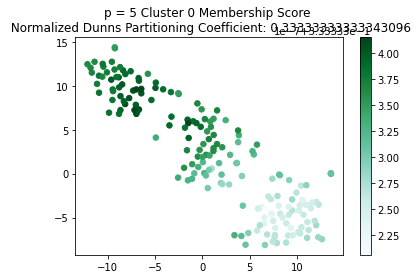

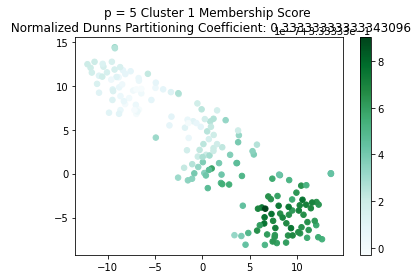

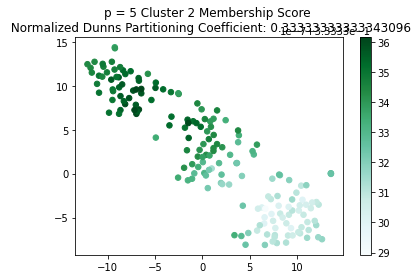

----------------------------------------


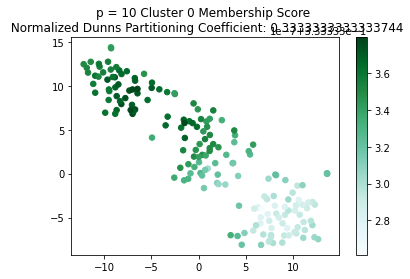

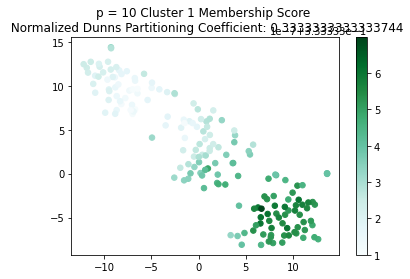

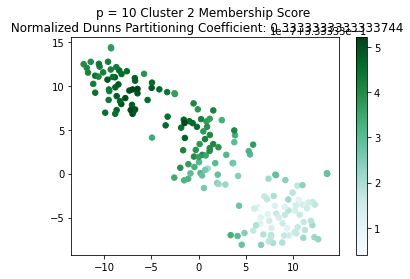

----------------------------------------


In [ ]:
# Number of clusters
K=3
for p in [1.001, 1.01,1.1,5,10]:
    cntr, W, _, _, _, _, pc = cmeans(X_array, c=K, m=p, error=1e-6, maxiter=20000, seed=1000)
    for i in range(0,K):
        dff['Cluster %s Membership Score'%str(i)]=W[i,:]
        # Plot the projected (x,y) coordinates
        points = plt.scatter(dff["x"], dff["y"],
                 c=dff['Cluster %s Membership Score'%str(i)], s=30, cmap="BuGn")
        plt.colorbar(points)
        plt.title('p = %s Cluster %s Membership Score \n Normalized Dunns Partitioning Coefficient: %s'%(p,str(i),pc))
        plt.show()
    print('----------------------------------------')

We tested Fuzzy c-Means and found it is more like hard assignment when p=1.01.

But what we observed in the hard assignment algorithms(kmeans and hierarchical) is: there are some wines that are close to other classes, and the hard assignment algorithms failed to classify them. So it would be if we can look at those wines in detail and do the classification more carefully. So here, setting p=1.1 might also be worth considering: when p=1.1 there are wines that appear to be "not so sure" about its home cluster.

## **Analysis Summary**

**Algorithm Comparison Summary**

Our research motivation is to see how the clusters are seperated form each other, and which clustering algorithm can give us a more accurate classification result.

After our exploring, we found that the k-means algorithm works the best in giving the classification because it gives higher adjusted rand score when compared to the actual classes. However, the hierarchical clustering with wart linkage is doing better in seperating the clusters (it has higher seperation and cohesion).

**Insights Summary**

We have explored a lot during this process. Before using this wine dataset, we took a long time searching for datasets that are really "clusterable", unfortunately we didn't find that much. We have tried two other different datasets, and for one of them we have gone very very deep - we did all of the preprocessing and we got a nice T-SNE plot. But when we try to run the clustering algorithms, we found it unclusterable.

This made us think of the drawbacks of clustering algorithms. Many of the algorithms like kmeans and dbscan are interesting and efficient, however when dealing with real-world data, it doesn't give us the result we want. It only performs well on a small and nicely balanced dataset. We are not saying that the algorithms are not good or the real-world data is not clusterable. What we realize is that, clustering might be too abstract for analyzing patterns in real-world data: it seeks to seperate a group of samples out from other samples, and it assumes the samples in a group share some common attributes. However the data is not always "spherical", not even "spiral" or "linear" like what we saw in this course. Sometimes there's no strong shape pattern in the dataset. And when this is true, it is really hard to find a good clustering algorithm or to get a pre



Cluster 0: Highest alcohol content(mean:~14%), Magnesium, Total ohenois, Ash, Flavanoids, Proathocyanins, OD280 or OD315 of diluted wines, proline
Lowest Acailinit of ash 
Cluster 2: Highest Malic Acid, Monflavanoid, Phenois, Color intensity,Lowest Hue


##  Team Member Project Contribution Report

Estimated percent contribution of each team member.


A brief description of the contributions of each team member.

Wanxing Dai(60%): 
Dataset suitability pre-analysis, Clustering Algorithms, post-analysis, slides.

Jing Huang(40%):
Data Research, EDA, Algorithm Selection Motivation, algorithm interpretation, feature engineering/running DBSCAN on a dataset that we finally didn't use